<a href="https://colab.research.google.com/github/IvaStival/DataScience/blob/master/RCNN/code/RCNN_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras.layers import Dense
from tensorflow.keras import Model, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
import cv2
import zipfile

In [ ]:
def unzipFolders(file_path, destiny):
  with zipfile.ZipFile(file_path, "r") as z:
    z.extractall(destiny)

In [ ]:
def showImages(img_path, csv_path, filename):
    csv_filename = filename.split('.')[0] + ".csv"

    image = cv2.imread(os.path.join(img_path, filename))
    df = pd.read_csv(os.path.join(csv_path, csv_filename))

    gtvalues = []
    plt.imshow(image)
    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1, "x2":x2, "y1":y1, "y2":y2})
        cv2.rectangle(image, (x1, y1), (x2, y2), (255,0,0), 2)
    plt.figure()
    plt.imshow(image)
    

In [ ]:
path = "/content/drive/MyDrive/DataScience/RCNN"

In [ ]:
image_zip = f"{path}/dataset/Images.zip"
csv_zip = f"{path}/dataset/Airplanes_Annotations.zip"
destiny = f"{path}/dataset"

# unzipFolders(image_zip, destiny)
# unzipFolders(csv_zip, destiny)

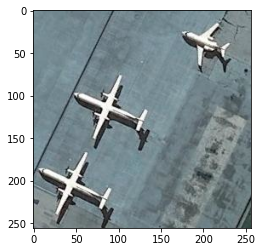

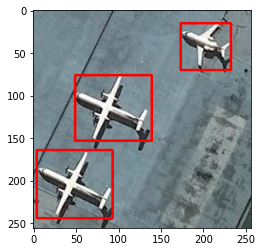

In [ ]:
showImages(f"{path}/dataset/Images", f"{path}/dataset/Airplanes_Annotations", "airplane_001.jpg")

In [ ]:
def get_iou(bb1, bb2):
    assert bb1["x1"] < bb1["x2"]
    assert bb1["y1"] < bb1["y2"]
    assert bb2["x1"] < bb2["x2"]
    assert bb2["y1"] < bb2["y2"]

    x_left   = max(bb1["x1"], bb2["x1"])
    y_top    = max(bb1["y1"], bb2["y1"])
    x_right  = min(bb1["x2"], bb2["x2"])
    y_bottom = min(bb1["y2"], bb2["y2"])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    interseption_area = (x_right - x_left) * (y_bottom - y_top)

    bb1_area = (bb1["x2"] - bb1["x1"]) * (bb1["y2"] - bb1["y1"])
    bb2_area = (bb2["x2"] - bb2["x1"]) * (bb2["y2"] - bb2["y1"])

    iou = interseption_area / float(bb1_area + bb2_area - interseption_area)

    assert iou >= 0.0
    assert iou <= 1.0
    
    return iou
 

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
def imageRecognition(path, csv_path, filename, e):
    train_images = []
    train_labels = []
    csv_filename = filename.split('.')[0] + ".csv"
#     print(f"{e} {filename}")

    image = cv2.imread(os.path.join(path, filename))
    df = pd.read_csv(os.path.join(csv_path, csv_filename))

    gtvalues = []

    for row in df.iterrows():
        x1 = int(row[1][0].split(" ")[0])
        y1 = int(row[1][0].split(" ")[1])
        x2 = int(row[1][0].split(" ")[2])
        y2 = int(row[1][0].split(" ")[3])
        gtvalues.append({"x1":x1, "x2":x2, "y1":y1, "y2":y2})

    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()

    counter = 0
    false_counter = 0
    flag = 0
    fflag = 0
    bflag = 0

    for e, result in enumerate(ssresults):
        if e < 2000 and flag == 0:
            for gtval in gtvalues:
                x, y, w, h = result

                iou = get_iou(gtval, {"x1":x, "x2":x+w, "y1":y, "y2":y+h})

                if counter < 30:
                    if iou > 0.70:
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(1)
                        counter += 1
                else:
                    fflag = 1
                if false_counter < 30:
                    if iou < 0.3:
                        timage = imout[y:y+h, x:x+w]
                        resized = cv2.resize(timage, (224, 224), interpolation = cv2.INTER_AREA)
                        train_images.append(resized)
                        train_labels.append(0)
                        false_counter += 1
                else:
                    bflag = 1
            if fflag == 1 and bflag == 1:
                print("inside")
                flag = 1
                
    return (train_images, train_labels)

In [ ]:
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == "binary":
            return np.hstack((Y, 1-Y))
        else:
            return Y
        
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == "binary":
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
def run():
    path = "/content/drive/MyDrive/DataScience/RCNN/dataset/Images"
    csv_path = "/content/drive/MyDrive/DataScience/RCNN/dataset/Airplanes_Annotations"
    
    train_images = []
    train_labels = []
    
    train_images, train_labels = imageRecognition(path, csv_path, "airplane_001.jpg", 1)
#     for i in train_images:
#         plt.imshow(i)
#         plt.show()
#     for e, i in enumerate(os.listdir(path)):
#         try:
#             if i.startswith("airplane"):
#                 tem_images, temp_labels = imageRecognition(path, csv_path, i, e)
#                 train_images += temp_images
#                 train_labels += temp_labels
#         except Exception as e:
#             print(e)
#             print("Error")
#             continue

    X_new = np.array(train_images)
    Y_new = np.array(train_labels)

    vggmodel = VGG16(weights="imagenet", include_top = True)

    for layers in (vggmodel.layers)[:15]:
        layers.trainable = False

    X = vggmodel.layers[-2].output
    predictions = Dense(2, activation = "softmax")(X)
    model_final = Model(vggmodel.input, predictions)
    opt = Adam(learning_rate = 0.001)
    model_final.compile(loss = "categorical_crossentropy", optimizer = opt, metrics = ["accuracy"])
    model_final.summary()
    
    lenc = MyLabelBinarizer()
    Y = lenc.fit_transform(Y_new)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.1)
    
    trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    traindata = trdata.flow(x=X_train, y=Y_train)
    
    tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
    testdata = tsdata.flow(x=X_test, y=Y_test)
    
    checkpoint = ModelCheckpoint("../models/ieeecnn_vgg16_1.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", period=1)
    
    early = EarlyStopping(monitor="val_loss", min_delta=0, patience=100, verbose=1, mode="auto")
    
    hist = model_final.fit(traindata, steps_per_epoch=2, epochs=10, validation_data=testdata, validation_steps=2, callbacks=[checkpoint, early])



In [ ]:
run()

inside
553476096/553467096 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                     